In [11]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('polishcsv.csv')

#testing random feature drops
#data = data.drop(columns='FT')
#data = data.drop(columns='FullK')
#data = data.drop(columns='diffKD')
#data = data.drop(columns='OB')
#data = data.drop(columns='OS')
#data = data.drop(columns='vol')
#data = data.drop(columns='s15')
#data = data.drop(columns='s30')
#data = data.drop(columns='s60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='Inertias')
#data = data.drop(columns='percBB')
#data = data.drop(columns='spreadRSI')
#data = data.drop(columns='ADX')
#data = data.drop(columns='RSI')
#data = data.drop(columns='Wpercent')
#data = data.drop(columns='acc')

#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='CLASS')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

#filtering before splitting could be useful if ABSOLUTELY mostly comprised of 'in'
#MARKET HOURS!
data = data.drop(data[data['ToD'] > 945].index)
data = data.drop(data[data['ToD'] < 545].index)
#OTHER MODIFICATIONS
#data = data.drop(data[data['feature'] condition].index)
data = data.drop(data[data['vol'] < 10000].index)

up_Rows = data.drop(data[data['CLASS'] != '_4up'].index)
upRRows = data.drop(data[data['CLASS'] != '_3upR'].index)
dnRRows = data.drop(data[data['CLASS'] != '_2dnR'].index)
dn_Rows = data.drop(data[data['CLASS'] != '_1dn'].index)

smallestClass = min(up_Rows.index.size, upRRows.index.size, dnRRows.index.size, dn_Rows.index.size)
print('Smallest Class Size:',smallestClass,'\n')

up_Rows = up_Rows.iloc[0:smallestClass]
upRRows = upRRows.iloc[0:smallestClass]
dnRRows = dnRRows.iloc[0:smallestClass]
dn_Rows = dn_Rows.iloc[0:smallestClass]

optData = pd.concat([up_Rows, upRRows, dnRRows, dn_Rows],axis=0)

print("OCCURANCES IN OPT DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))


#percIn = data.size/(inRows.size*2)
#percNin = data.size/(NinRows.size*2)
weight_for_0 = .25
weight_for_1 = .25
weight_for_2 = .25
weight_for_3 = .25
cw = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = optData.iloc[:, :-1].values
y = optData.iloc[:, -1].values

#SMOTE OVERSAMPLING________________

#smote = SMOTE()
#X, y = smote.fit_resample(X,y)
#print('\n[PRE-SPLIT] Resampled Data size:',X.size,'--',y.size)

#__________________________________

#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# one-hot encode ? 

from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#y_test = to_categorical(y_test, num_classes=4)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=646,
    decay_rate=0.99,
    staircase=True)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.7)
opt3 = SGD(learning_rate=lr_schedule)

from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

get_custom_objects().clear()
@register_keras_serializable(name="custom_loss")

def custom_loss(y_true, y_pred):
    # Convert one-hot encoded labels to class indices
    true_class = K.argmax(y_true, axis=-1)
    pred_class = K.argmax(y_pred, axis=-1)

    # Create a matrix where misclassifications (farthest ones) are heavily penalized
    inverse_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 3)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 0))   # True class 3, predicted class 0
    )
    bad1_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 2)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 1), K.equal(pred_class, 3)),  # True class 0, predicted class 3
    )
    bad2_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 2), K.equal(pred_class, 0)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 1))   # True class 3, predicted class 0
    )
    # Create a matrix where correct predictions for 0-0 and 3-3 are rewarded
    extrema_correct = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 0)),  # True class 0, predicted class 0
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 3)),  # True class 1, predicted class 1
    )
    fair_correct = tf.logical_or(
        tf.logical_and(K.equal(true_class, 1), K.equal(pred_class, 1)),  # True class 2, predicted class 2
        tf.logical_and(K.equal(true_class, 2), K.equal(pred_class, 2))   # True class 3, predicted class 3
    )
    

    # Standard categorical crossentropy loss
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Add an additional penalty for farthest misclassifications
    pen_inverse = 2.0  # You can adjust this penalty factor
    pen_inverse_loss = K.cast(inverse_misclass, tf.float32) * pen_inverse

    pen_bad1 = 1.0  # You can adjust this penalty factor
    pen_bad1_loss = K.cast(bad1_misclass, tf.float32) * pen_bad1

    pen_bad2 = 1.0  # You can adjust this penalty factor
    pen_bad2_loss = K.cast(bad2_misclass, tf.float32) * pen_bad2

    # Add a reward for correct 0-0 and 3-3 predictions (negative penalty)
    rew_extrema = 2.5  # You can adjust this reward factor
    rew_extrema_gain = K.cast(extrema_correct, tf.float32) * rew_extrema

    rew_fair = 1.5  # You can adjust this reward factor
    rew_fair_gain = K.cast(fair_correct, tf.float32) * rew_fair

    # Return the combined loss: base loss + penalties - rewards
    return base_loss + (pen_inverse_loss + pen_bad1_loss + pen_bad2_loss) - (rew_extrema_gain + rew_fair_gain)

loaded_model = tf.keras.models.load_model('multi_oh3.keras')#,custom_objects={"custom_loss":custom_loss})
met = ['Accuracy','Precision','Recall']
loaded_model.compile(optimizer=opt3, loss=custom_loss, metrics=met)


TESTED FEATURES: 
Index(['FT', 'FullK', 'diffKD', 'OB', 'OS', 'vol', 's15', 's30', 's60', 'ToD',
       'Inertias', 'percBB', 'spreadRSI', 'ADX', 'RSI', 'Wpercent', 'acc'],
      dtype='object')
TESTING FOR: 
CLASS
OCCURANCES IN RAW DATA FOR CLASS: 
{'_1dn': 113, '_2dnR': 102, '_3upR': 109, '_4up': 103}
Smallest Class Size: 29 

OCCURANCES IN OPT DATA FOR CLASS: 
{'_1dn': 29, '_2dnR': 29, '_3upR': 29, '_4up': 29}


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


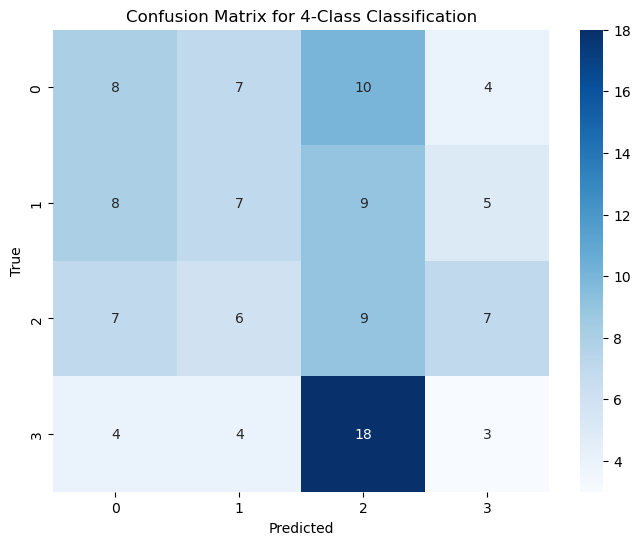

In [12]:
#predicting the test set results
y_true = np.argmax(y, axis=1)  # Convert one-hot to class indices if needed
y_pred = np.argmax(loaded_model.predict(X), axis=1)  # Predictions to class indices

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4-Class Classification')
plt.show()

#PRINTS OUT ALL GUESSES
#[print(x) for x in y_pred]